**SETTING**

In [ ]:
# !nvidia-smi

In [1]:
import os
import pandas as pd
import numpy as np
#os.chdir('./data')
#os.getcwd()

구글 세팅

In [12]:
# !pip install transformers pororo kss wandb

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# os.chdir('./drive/MyDrive/BoostCamp/project_lv1/data')
# os.getcwd()

'/content/drive/MyDrive/BoostCamp/project_lv1/data'

In [4]:
train_pd = pd.read_csv("train.csv")
#print(train_pd.info(),end='\n\n')

# **Preprocessing**
참고 : https://wikidocs.net/92961   
참고 : https://github.com/haven-jeon/PyKoSpacing   

- spell_checker(맞춤법 교정) : 네이버 한글 맞춤법 검사기를 바탕으로 만들어진 패키지, 이 패키지는 띄어쓰기 또한 보정됨
- Spacing(띄어쓰기 교정) : 대용량 코퍼스를 학습하여 만들어진 띄어쓰기 딥 러닝 모델로 준수한 성능을 가지고 있음

> spell_checker 라이브러리만 사용할 계획 : 특수문자 제거 후, 맞춤법 및 띄어쓰기 교정

In [7]:
#!pip install git+https://github.com/ssut/py-hanspell.git
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git
from hanspell import spell_checker      
#from pykospacing import Spacing : 설치 주의
import re

In [9]:
#1. 특수문자 제거 : 영어 살려둠 : pc방, LG전자, <\PERSON> 같은 단어도 제거되기 때문에 영문자 제거 보류
def remove(data):
    data.sentence_1 = data.sentence_1.str.replace('[^\uAC00-\uD7A30-9a-zA-Z\s]', '')
    data.sentence_2 = data.sentence_2.str.replace('[^\uAC00-\uD7A30-9a-zA-Z\s]', '')
    return data

#2.맞춤법 > 특수문자 제거 후 사용하기(ParseError 발생)
def checker(data):
    for ind in range(len(data)):
        origin_1 = data.sentence_1[ind]
        origin_2 = data.sentence_2[ind]
        
        spelled_sent_1 = spell_checker.check(origin_1).checked
        spelled_sent_2 = spell_checker.check(origin_2).checked
        
        data.sentence_1[ind] = spelled_sent_1        # 변경
        data.sentence_2[ind] = spelled_sent_2        # 변경
        
        # 확인용
        print('\n\n[',ind,']origin:',origin_1,'\n[',ind,']change :',data.sentence_1[ind])
        
        
    return data

## Spacing : 미사용 예정
#3-1. 공백제거
def blank_remove(data):
    #공백제거
    # for ind in range(len(data)):
    #     data.sentence_1[ind] = data.sentence_1[ind].replace(' ','')
    #     data.sentence_2[ind] = data.sentence_2[ind].replace(' ','')
    data.sentence_1 = data.sentence_1.str.replace(' ','')
    data.sentence_2 = data.sentence_2.str.replace(' ','')
    return data

#3-2. 띄어쓰기
def re_spacing(data):
    spacing = Spacing()
    
    for ind in range(len(data)):
        data.sentence_1[ind] = spacing(data.sentence_1[ind])
        data.sentence_2[ind] = spacing(data.sentence_2[ind])
    return data

#4 문장길이 0인 것 삭제 처리

### 1: 문장 교정

- ch_train(spell_checker) : train_pd(특수문자 제거 후) > 맞춤법 교정&띄어쓰기
- sp_train(Spacing) : train_pd > 띄어쓰기 교정

In [ ]:
#1. 맞춤법 : 오래걸림
#특수문자 제거 후, 맞춤법
# re_data = remove(train_pd)
# ch_train = checker(re_data)
# ch_train

#2. 공백제거 후, 띄어쓰기 : 오래걸림
#bl_train = blank_remove(train_pd)
#sp_train = re_spacing(bl_train)
#sp_train[:20]

데이터 확인

In [ ]:
# ch_train

### 1-2 :문장길이 확인해서 제거할 것, 중복 확인하기

In [ ]:
# max_len = np.max(ch_train['sentence_1'].str.len())
# min_len = np.min(ch_train['sentence_1'].str.len())
# mean_len = np.mean(ch_train['sentence_1'].str.len())

# print('Max sentence_1 Length: ', max_len)
# print('Min sentence_1 Length: ', min_len)
# print('Mean sentence_1 Lenght: ', mean_len, '\n')

# max_len = np.max(ch_train['sentence_2'].str.len())
# min_len = np.min(ch_train['sentence_2'].str.len())
# mean_len = np.mean(ch_train['sentence_2'].str.len())

# print('Max sentence_2 Length: ', max_len)
# print('Min sentence_2 Length: ', min_len)
# print('Mean sentence_2 Lenght: ', mean_len)

- sentence_2 Length:  0 확인하기

In [ ]:
# ch_train[ch_train['sentence_2'].str.len()==0]

In [ ]:
#원본
# train_pd.loc[8140]

- 결측값 제거하기 : 1 row 제거 >> 9323 rows

In [ ]:
# final_train = ch_train[ch_train["sentence_2"] != ""]
# final_train.info()

In [ ]:
# from collections import Counter
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10,7.5))
# plt.hist(final_train['sentence_1'].str.len(), alpha=0.5, color='orange',label = 'sentence_1')
# plt.hist(final_train['sentence_2'].str.len(), alpha=0.5, color='#bce29e',label = 'sentence_2')
# plt.legend()
# #plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정

# plt.show()

# **DA**

### 1 :증강 exchange
- add_train(18646 rows) : ch_train(특수문자제거, 문장교정 및 띄어쓰기) + 문장 교환으로 데이터 증강

In [ ]:
# # 주의
# data_re = final_train

# change_sent = pd.DataFrame({
#     'id' : data_re['id'],
#     'source' :data_re['source'],
#     'sentence_1' :data_re['sentence_2'] ,
#     'sentence_2' : data_re['sentence_1'],
#     'label' : data_re['label'],
#     'binary-label' : data_re['binary-label']
#     })
# add_train = pd.concat([data_re,change_sent],ignore_index=True)

In [5]:
#add_train.to_csv('add_train.csv',index=False)
add_train = pd.read_csv("add_train.csv")
add_train

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도 있고 반전도 있고 여느 한국 영화 쓰레기들하고는 차원이 다르네요,반전도 있고 사랑도 있고 재미도 있네요,2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근 권한이 없다고 뜹니다,오 액세스 권한이 없다고 합니다,4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요,주택청약 무주택 기준 변경해주세요,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사 후 처음 대면으로 만나 반가웠습니다,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯 뿌듯하네요,꼬옥 실제로 한번 뵈어요 뿌뿌뿌,0.0,0.0
...,...,...,...,...,...,...
18641,boostcamp-sts-v1-train-9319,petition-sampled,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야 합니다,0.2,0.0
18642,boostcamp-sts-v1-train-9320,petition-sampled,여성가족부 폐지를 청원합니다,여성가족부의 폐지를 원합 니드,4.2,1.0
18643,boostcamp-sts-v1-train-9321,petition-sampled,공무원 봉급 좀 줄이지 좀 마세요,국회의원들 월급 좀 줄여주세요,0.6,0.0
18644,boostcamp-sts-v1-train-9322,slack-sampled,오늘 못 먹은 밥은 꼭 담에 먹기로 하고요,오늘 못한 점심은 다음에 다시 트라이 하기로 해요,3.2,1.0


## 2 :Back Translation (with Pororo MT) 
1참조 : https://dacon.io/competitions/official/235875/codeshare/4625?page=1&dtype=recent   
2참조 : https://github.com/rickiepark/nlp-with-pytorch/blob/main/pororo_nlp.ipynb   

- 2021년 초에 카카오브레인(https://www.kakaobrain.com/)에서 다양한 한글 자연어 처리 작업을 위한 pororo('뽀로로'라고 읽음)(https://github.com/kakaobrain/pororo) 파이썬 라이브러리
- 기계번역은 페이스북에서 만든 fairseq의 TransformerModel모델의 사용함
- source가 rtt인 데이터만 역변환 시도
- pororo_train

### 2-1 :역번역할 데이터셋 구축 : rtt (5302 rows)

In [6]:
mt_list = ['slack-rtt','petition-rtt','nsmc-rtt']       # 2092/ 1634 /1576 == 5302 rows
mt_data = add_train[add_train.source.isin(mt_list)]
mt_data

,id,source,sentence_1,sentence_2,label,binary-label
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근 권한이 없다고 뜹니다,오 액세스 권한이 없다고 합니다,4.2,1.0
5,boostcamp-sts-v1-train-005,nsmc-rtt,오마이가뜨지져스크롸이스트휏,오 마이 갓 지저스 스트론 이스트 팬,2.6,1.0
6,boostcamp-sts-v1-train-006,slack-rtt,전 암만 찍어도 까만 하늘,암만 찍어도 하늘은 까맣다,3.6,1.0
10,boostcamp-sts-v1-train-010,slack-rtt,그 책부터 얼른 꺼내봐야겠어요,책에서 꺼내야겠어요,2.4,0.0
12,boostcamp-sts-v1-train-012,nsmc-rtt,오랜만에 존 큐잭의 연기 보니 좋네요 Good,오랜만에 존 큐잭의 연기를 보니 반갑다 좋아요,3.8,1.0
...,...,...,...,...,...,...
18619,boostcamp-sts-v1-train-9297,slack-rtt,오늘은 날씨가 너무 좋았어 굿굿,크 오늘 날씨 너무 좋았는데 대박,4.0,1.0
18620,boostcamp-sts-v1-train-9298,petition-rtt,북한 연락사무소 리모델링 97억 8000만 원 급하니까 나중에 계산할게,북한 연락사무소 리모델링 97억 8천만 원 시급한 일이라 사후 계산한다고,4.2,1.0
18626,boostcamp-sts-v1-train-9304,petition-rtt,독도가 표시된 한반도기 사용,독도 표시된 한반도기 사용,5.0,1.0
18629,boostcamp-sts-v1-train-9307,slack-rtt,프로젝트 멘토를 만난 기분으로 인사를 받았습니다,프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다,2.8,1.0


### 2-2 :뽀로로

In [16]:
# !pip install --upgrade pip                            # pip versio업그레이드
# !git clone https://github.com/kakaobrain/pororo.git     #라이브러리 설치

In [7]:
# cd pororo         # 디렉토리 이동
# !pip install -e .
# 런타임 재시작 >> 한번만 해도 되는 작업.

In [8]:
from pororo import Pororo
mt = Pororo(task="translation", lang="multi")
# model='transformer.large.multi.fast.mtpg' : 기본 모델 외에 약간의 성능을 희생하면서 2배 정도 빠른 속도를 냄 > 오류
# model='abstractive' :: !pip install -U transformers==4.7.0 > Pororo(task='summary', lang='ko', model='abstractive')

In [ ]:
# def back_trans_pororo(original_text, lang='en'):
#     text_to_lang = mt(original_text, src="ko", tgt=lang)
#     new_text = mt(text_to_lang, src=lang, tgt="ko")
#     return new_text

# print('origin ;',add_train.sentence_1[0])
# print('translation ;',back_trans_pororo(add_train.sentence_1[0]))

In [9]:
def back_trans_pororo(original_text, lang='en'):
    #print('origin : ',original_text)
    text_to_lang = mt(original_text, src="ko", tgt=lang)
    new_text = mt(text_to_lang, src=lang, tgt="ko")
    #print('after : ',new_text)
    #print()
    return new_text

In [11]:
# progress_apply를 사용하려면 필수적으로 사용.
from tqdm import tqdm
tqdm.pandas()

lang = 'en'
pororo_data_sent1 = mt_data.copy()
pororo_data_sent1['sentence_1'] = mt_data['sentence_1'].progress_apply(lambda x: back_trans_pororo(x, lang=lang))
#pororo_data_sent1.to_csv('pororo_sent1.csv',index=False)

100%|██████████| 5302/5302 [55:08<00:00,  1.60it/s]


In [12]:
pororo_data_sent2 = mt_data.copy()
pororo_data_sent2['sentence_2'] = mt_data['sentence_2'].progress_apply(lambda x: back_trans_pororo(x, lang=lang))
#pororo_data_sent2.to_csv('pororo_sent2.csv',index=False)

100%|██████████| 5302/5302 [53:14<00:00,  1.66it/s]


- pororo_data_sent1 : sentence_1만 역번역한 dataframe
- pororo_data_sent2 : sentence_2만 역번역한 dataframe
> pororo_train = add_train + pororo_data_sent1 + pororo_data_sent1

In [32]:
pororo_train = pd.concat([add_train,pororo_data_sent1,pororo_data_sent2])
pororo_train.to_csv('pororo_both_train.csv',index=False)
pororo_both = pd.read_csv("pororo_both_train.csv")

#인덱스 확인 내용 확인
pororo_both

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도 있고 반전도 있고 여느 한국 영화 쓰레기들하고는 차원이 다르네요,반전도 있고 사랑도 있고 재미도 있네요,2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근 권한이 없다고 뜹니다,오 액세스 권한이 없다고 합니다,4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요,주택청약 무주택 기준 변경해주세요,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사 후 처음 대면으로 만나 반가웠습니다,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯 뿌듯하네요,꼬옥 실제로 한번 뵈어요 뿌뿌뿌,0.0,0.0
...,...,...,...,...,...,...
29245,boostcamp-sts-v1-train-9297,slack-rtt,오늘은 날씨가 너무 좋았어 굿굿,좋은 날이었지만 멋진 밤이었다,4.0,1.0
29246,boostcamp-sts-v1-train-9298,petition-rtt,북한 연락사무소 리모델링 97억 8000만 원 급하니까 나중에 계산할게,"북한 연락사무소를 리모델링하는 데 97억8,000만원이 시급한 문제다.",4.2,1.0
29247,boostcamp-sts-v1-train-9304,petition-rtt,독도가 표시된 한반도기 사용,독도가 표시된 한반도 깃발의 사용,5.0,1.0
29248,boostcamp-sts-v1-train-9307,slack-rtt,프로젝트 멘토를 만난 기분으로 인사를 받았습니다,나는 프로젝트 멘토를 만나는 느낌에 인사를 받았다,2.8,1.0


In [29]:
pororo_both.label

0        2.2
1        4.2
2        2.4
3        3.0
4        0.0
        ... 
29245    4.0
29246    4.2
29247    5.0
29248    2.8
29249    4.4
Name: label, Length: 29250, dtype: float64

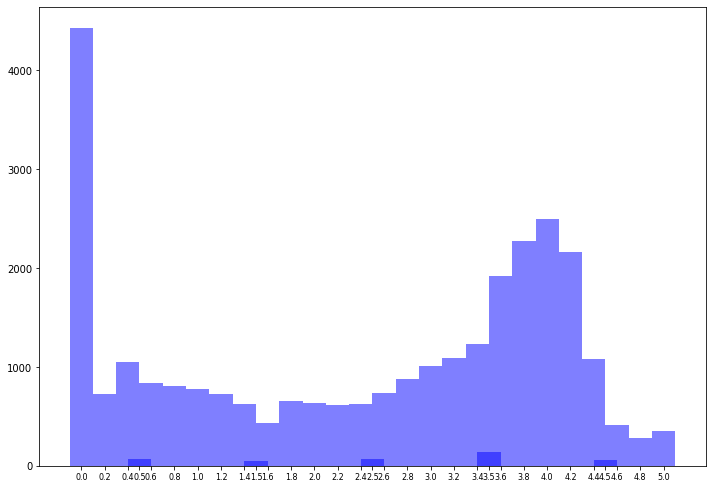

In [31]:
import matplotlib.pyplot as plt
feature = pororo_both['label']

plt.figure(figsize=(10,7.5))
#plt.title('Label Count', fontsize=20)

temp = feature.value_counts()  
plt.bar(temp.keys(), temp.values, width=0.2, color='b', alpha=0.5)
plt.xticks(temp.keys(), fontsize=8) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

---